# Basic to Intermediate GeoPandas Tutorial

This notebook introduces GeoPandas and demonstrates fundamental geospatial operations.

## Topics Covered:
1. Introduction to GeoPandas and GeoDataFrames
2. Reading/writing geospatial data
3. Basic plotting and visualization
4. Coordinate Reference Systems (CRS)
5. Spatial operations (buffers, centroids, area)
6. Spatial joins and relationships
7. Working with real-world datasets


In [1]:
# Fix for PROJ database path issue
import os
import sys

# Set environment variables to use Homebrew PROJ installation
os.environ['PROJ_DATA'] = '/opt/homebrew/share/proj'
os.environ['PROJ_LIB'] = '/opt/homebrew/share/proj'
os.environ['PROJ_NETWORK'] = 'OFF'

# Now import pyproj
import pyproj
from pyproj import datadir

# Set data directory to Homebrew PROJ
datadir.set_data_dir('/opt/homebrew/share/proj')

print(f"✓ pyproj {pyproj.__version__}")
print(f"✓ PROJ data dir: {datadir.get_data_dir()}")

# Test CRS creation
try:
    from pyproj import CRS
    test_crs = CRS.from_epsg(4326)
    print(f"✓ CRS working: {test_crs.name}")
except Exception as e:
    print(f"✗ CRS failed: {e}")


✓ pyproj 3.7.2
✓ PROJ data dir: /opt/homebrew/share/proj
✓ CRS working: WGS 84


In [3]:
# Import required libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import numpy as np

# Set display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Introduction to GeoPandas and GeoDataFrames

GeoPandas extends pandas to allow spatial operations on geometric types. The core data structure is the `GeoDataFrame`, which is like a pandas DataFrame but with a special `geometry` column.


In [4]:
# Create a simple GeoDataFrame from scratch
cities_data = {
    'city': ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix'],
    'population': [8336817, 3979576, 2693976, 2320268, 1680992],
    'latitude': [40.7128, 34.0522, 41.8781, 29.7604, 33.4484],
    'longitude': [-74.0060, -118.2437, -87.6298, -95.3698, -112.0740]
}

# Create point geometries from lat/lon
geometry = [Point(xy) for xy in zip(cities_data['longitude'], cities_data['latitude'])]

# Create GeoDataFrame
cities_gdf = gpd.GeoDataFrame(
    cities_data, 
    geometry=geometry,
    crs='EPSG:4326'  # WGS84 coordinate system
)

print("GeoDataFrame Structure:")
print(cities_gdf.head())
print(f"\nCRS: {cities_gdf.crs}")
print(f"Geometry type: {cities_gdf.geometry.geom_type.unique()}")


GeoDataFrame Structure:
          city  population  latitude  longitude                   geometry
0     New York     8336817   40.7128   -74.0060    POINT (-74.006 40.7128)
1  Los Angeles     3979576   34.0522  -118.2437  POINT (-118.2437 34.0522)
2      Chicago     2693976   41.8781   -87.6298   POINT (-87.6298 41.8781)
3      Houston     2320268   29.7604   -95.3698   POINT (-95.3698 29.7604)
4      Phoenix     1680992   33.4484  -112.0740   POINT (-112.074 33.4484)

CRS: EPSG:4326
Geometry type: ['Point']


## 2. Basic Visualization


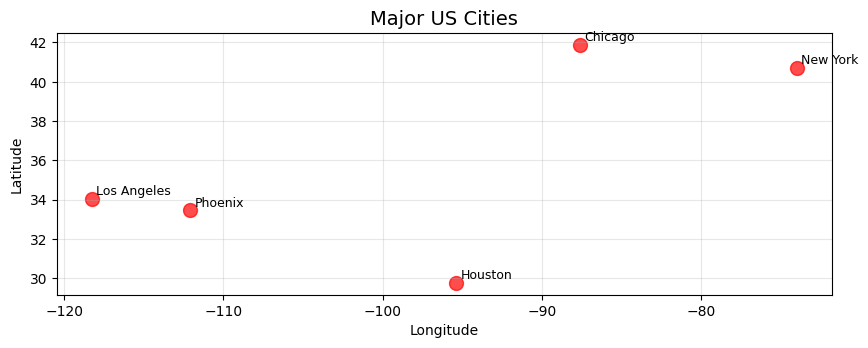

In [5]:
# Simple plot of cities
fig, ax = plt.subplots(figsize=(10, 6))
cities_gdf.plot(ax=ax, color='red', markersize=100, alpha=0.7)

# Add city labels
for idx, row in cities_gdf.iterrows():
    ax.annotate(row['city'], xy=(row.geometry.x, row.geometry.y), 
                xytext=(3, 3), textcoords='offset points', fontsize=9)

plt.title('Major US Cities', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.show()


## 3. Working with Real-World Data

GeoPandas comes with built-in datasets for testing and learning.


In [6]:
# Load world dataset directly from Natural Earth
world = gpd.read_file('https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip')

print("World Dataset Info:")
print(world.head())
print(f"\nShape: {world.shape}")
print(f"Columns: {world.columns.tolist()}")


World Dataset Info:
        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  \
0         0      2  Sovereign country   1                         Fiji   
1         0      2  Sovereign country   1  United Republic of Tanzania   
2         0      2      Indeterminate   1               Western Sahara   
3         0      2  Sovereign country   1                       Canada   
4         1      2            Country   1     United States of America   

  ADM0_A3  GEOU_DIF                   GEOUNIT GU_A3  S

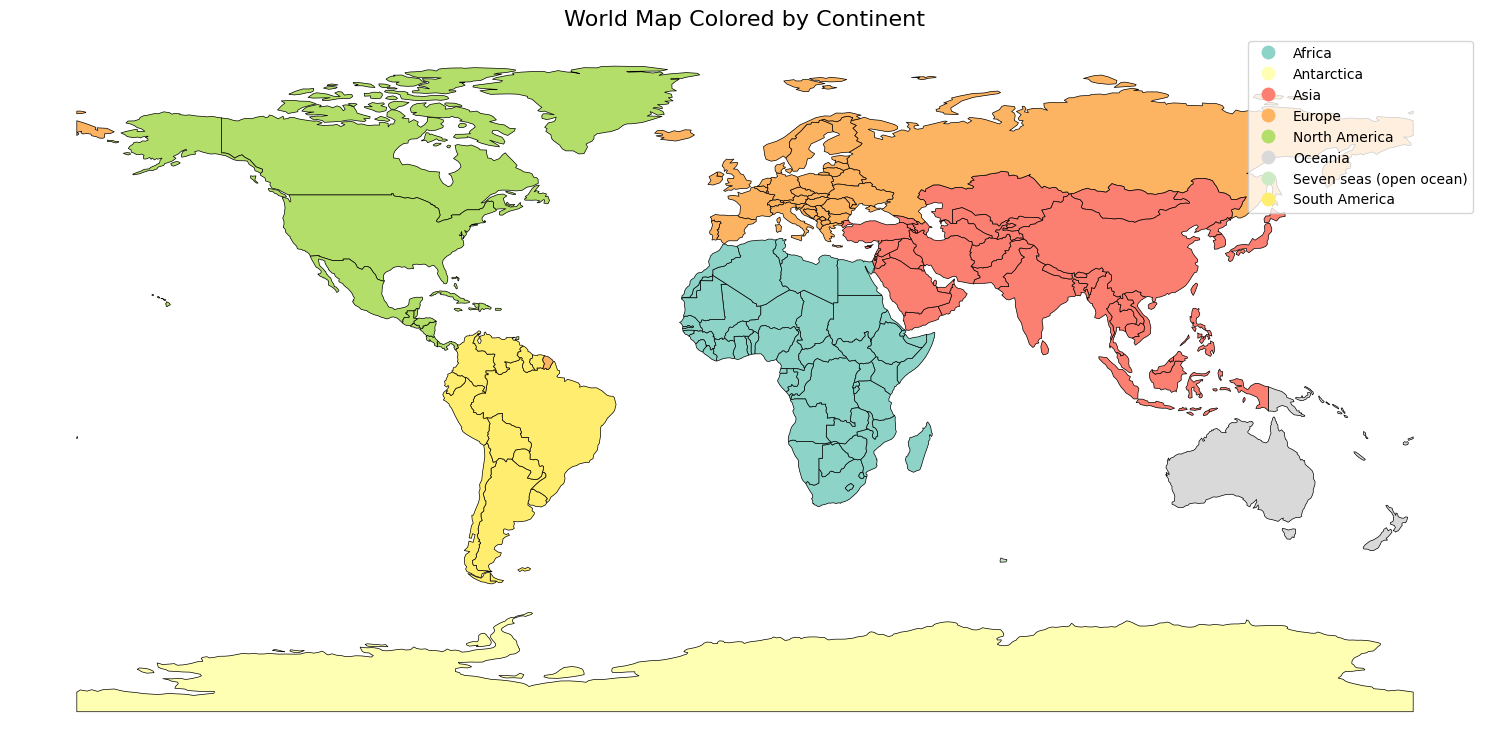

In [7]:
# Plot world map colored by continent
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, column='CONTINENT', legend=True, 
           cmap='Set3', edgecolor='black', linewidth=0.5)
plt.title('World Map Colored by Continent', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


## 4. Coordinate Reference Systems (CRS)

Understanding and transforming CRS is crucial for accurate spatial analysis.


In [8]:
# Filter to North America
north_america = world[world['CONTINENT'] == 'North America'].copy()

print(f"Original CRS: {north_america.crs}")
print(f"Original bounds: {north_america.total_bounds}")

# Transform to a projected CRS (Albers Equal Area for North America)
north_america_projected = north_america.to_crs('ESRI:102008')

print(f"\nProjected CRS: {north_america_projected.crs}")
print(f"Projected bounds: {north_america_projected.total_bounds}")


Original CRS: EPSG:4326
Original bounds: [-171.7911106     7.22054149  -12.20855      83.64513   ]

Projected CRS: ESRI:102008
Projected bounds: [-6040576.68931711 -3522576.13233246  3971637.22673786  5477009.86478234]


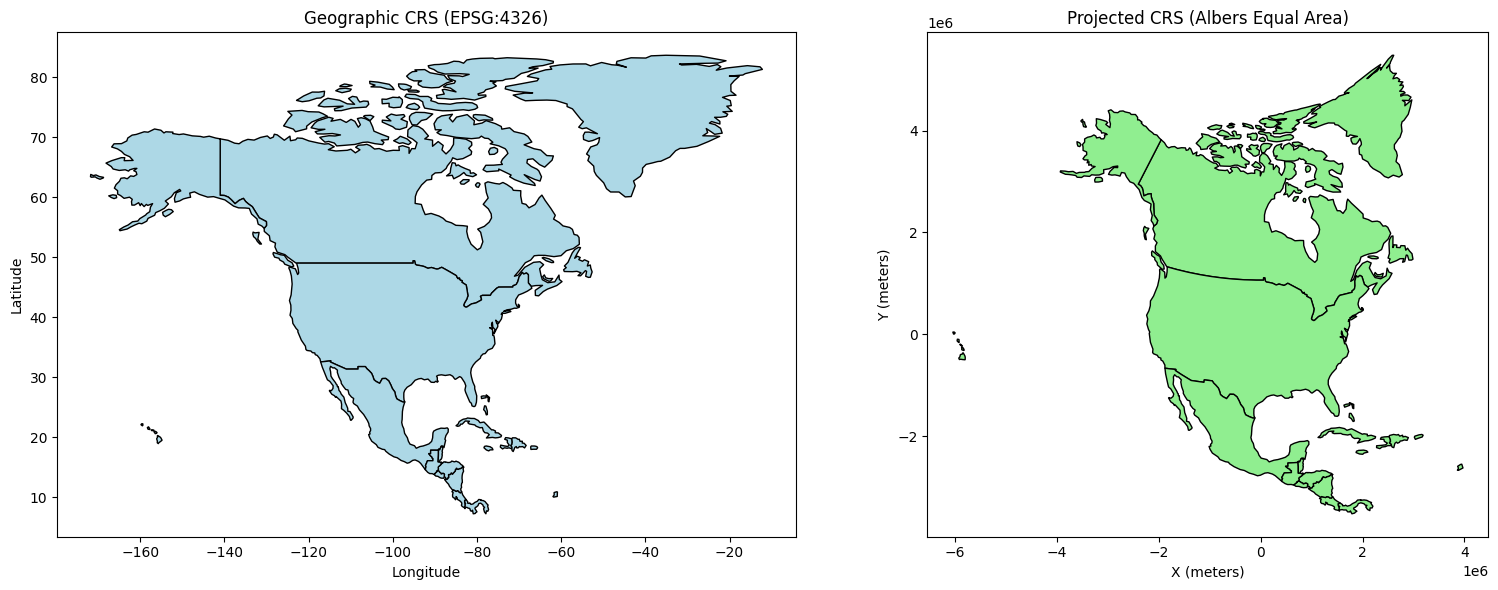

In [9]:
# Compare geographic vs projected plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

north_america.plot(ax=ax1, color='lightblue', edgecolor='black')
ax1.set_title('Geographic CRS (EPSG:4326)', fontsize=12)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

north_america_projected.plot(ax=ax2, color='lightgreen', edgecolor='black')
ax2.set_title('Projected CRS (Albers Equal Area)', fontsize=12)
ax2.set_xlabel('X (meters)')
ax2.set_ylabel('Y (meters)')

plt.tight_layout()
plt.show()


## 5. Spatial Operations

### 5.1 Area Calculations


In [10]:
# Calculate area (need projected CRS for accurate results)
world_projected = world.to_crs('ESRI:54009')  # Mollweide projection

# Calculate area in square kilometers
world_projected['area_km2'] = world_projected.geometry.area / 1_000_000

# Top 10 countries by area
top_10_countries = world_projected.nlargest(10, 'area_km2')[['NAME', 'area_km2']]
print("Top 10 Countries by Area:")
print(top_10_countries.to_string(index=False))


Top 10 Countries by Area:
                    NAME     area_km2
                  Russia 1.695332e+07
              Antarctica 1.199036e+07
                  Canada 9.996089e+06
United States of America 9.526449e+06
                   China 9.428688e+06
                  Brazil 8.559708e+06
               Australia 7.719210e+06
                   India 3.157537e+06
               Argentina 2.790478e+06
              Kazakhstan 2.726129e+06


### 5.2 Buffers


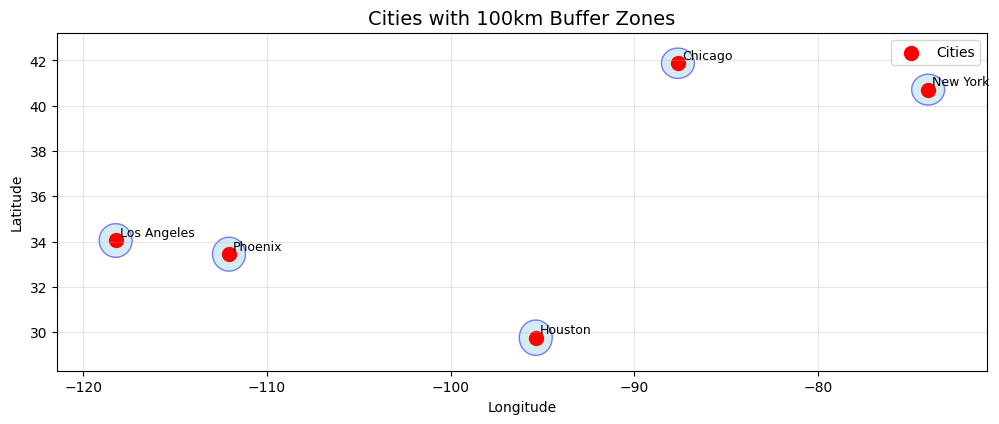

In [11]:
# Create buffers around cities (project first for accurate distance)
# Using Web Mercator for this example
cities_projected = cities_gdf.to_crs('EPSG:3857')

# Create 100km buffer around each city
buffer_distance = 100_000  # 100km in meters
cities_buffered = cities_projected.copy()
cities_buffered['geometry'] = cities_projected.geometry.buffer(buffer_distance)

# Convert back to geographic CRS for plotting
cities_buffered_geo = cities_buffered.to_crs('EPSG:4326')
cities_gdf_copy = cities_gdf.copy()

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
cities_buffered_geo.plot(ax=ax, color='lightblue', alpha=0.5, edgecolor='blue', label='100km Buffer')
cities_gdf_copy.plot(ax=ax, color='red', markersize=100, label='Cities')

for idx, row in cities_gdf.iterrows():
    ax.annotate(row['city'], xy=(row.geometry.x, row.geometry.y), 
                xytext=(3, 3), textcoords='offset points', fontsize=9)

plt.title('Cities with 100km Buffer Zones', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 5.3 Centroids


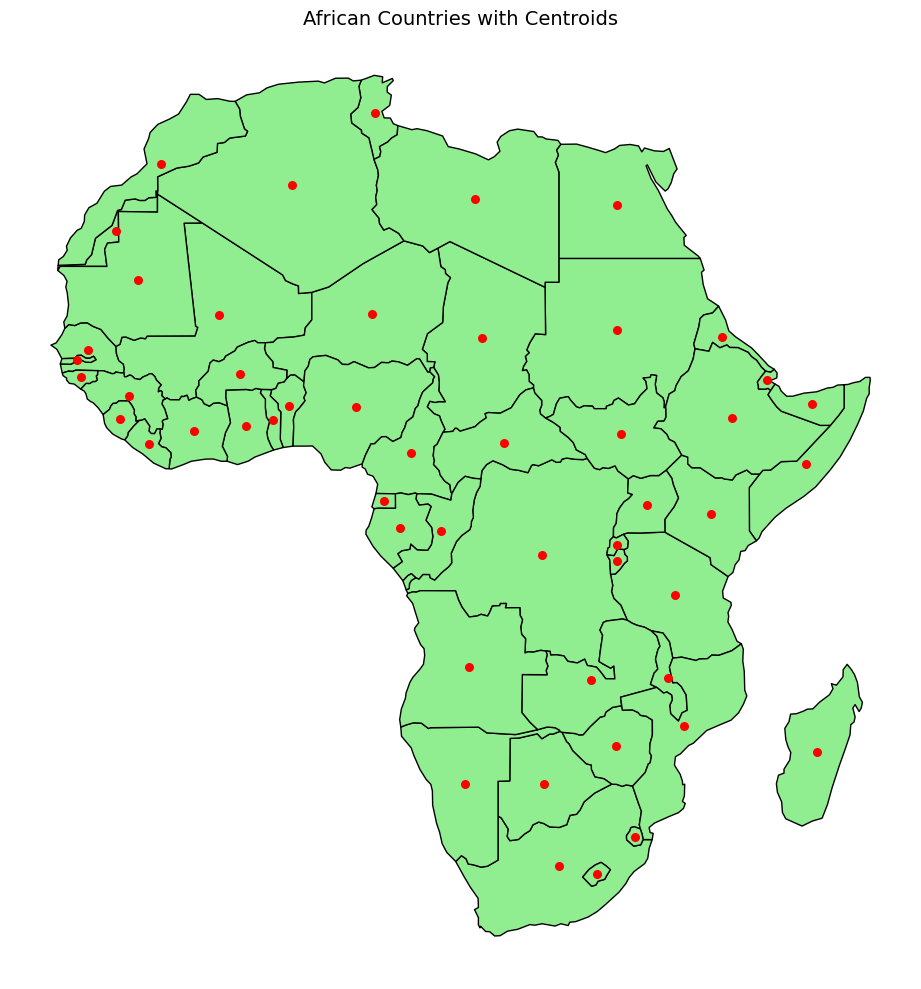

In [12]:
# Calculate centroids of countries
world_with_centroids = world.copy()
world_with_centroids['centroid'] = world_with_centroids.geometry.centroid

# Plot Africa with country centroids
africa = world[world['CONTINENT'] == 'Africa'].copy()
africa_centroids = africa.geometry.centroid

fig, ax = plt.subplots(figsize=(12, 10))
africa.plot(ax=ax, color='lightgreen', edgecolor='black')
gpd.GeoSeries(africa_centroids).plot(ax=ax, color='red', markersize=30)

plt.title('African Countries with Centroids', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


## 6. Spatial Joins and Relationships

Spatial joins allow us to combine data based on spatial relationships.


In [13]:
# Create some sample points of interest (POIs)
poi_data = {
    'name': ['Statue of Liberty', 'Hollywood Sign', 'Willis Tower', 'Space Center Houston', 'Desert Botanical Garden'],
    'type': ['Monument', 'Landmark', 'Building', 'Museum', 'Garden'],
    'longitude': [-74.0445, -118.3215, -87.6359, -95.0979, -111.9451],
    'latitude': [40.6892, 34.1341, 41.8789, 29.5519, 33.4625]
}

poi_geometry = [Point(xy) for xy in zip(poi_data['longitude'], poi_data['latitude'])]
poi_gdf = gpd.GeoDataFrame(poi_data, geometry=poi_geometry, crs='EPSG:4326')

print("Points of Interest:")
print(poi_gdf)


Points of Interest:
                      name      type  longitude  latitude  \
0        Statue of Liberty  Monument   -74.0445   40.6892   
1           Hollywood Sign  Landmark  -118.3215   34.1341   
2             Willis Tower  Building   -87.6359   41.8789   
3     Space Center Houston    Museum   -95.0979   29.5519   
4  Desert Botanical Garden    Garden  -111.9451   33.4625   

                    geometry  
0   POINT (-74.0445 40.6892)  
1  POINT (-118.3215 34.1341)  
2   POINT (-87.6359 41.8789)  
3   POINT (-95.0979 29.5519)  
4  POINT (-111.9451 33.4625)  


In [14]:
# Spatial join: Which POIs are within city buffers?
poi_in_buffers = gpd.sjoin(
    poi_gdf, 
    cities_buffered_geo, 
    how='left', 
    predicate='within'
)

print("POIs matched to cities:")
print(poi_in_buffers[['name', 'type', 'city', 'population']])


POIs matched to cities:
                      name      type         city  population
0        Statue of Liberty  Monument     New York     8336817
1           Hollywood Sign  Landmark  Los Angeles     3979576
2             Willis Tower  Building      Chicago     2693976
3     Space Center Houston    Museum      Houston     2320268
4  Desert Botanical Garden    Garden      Phoenix     1680992


## 7. Creating Custom Geometries

Let's create some custom geometric shapes.


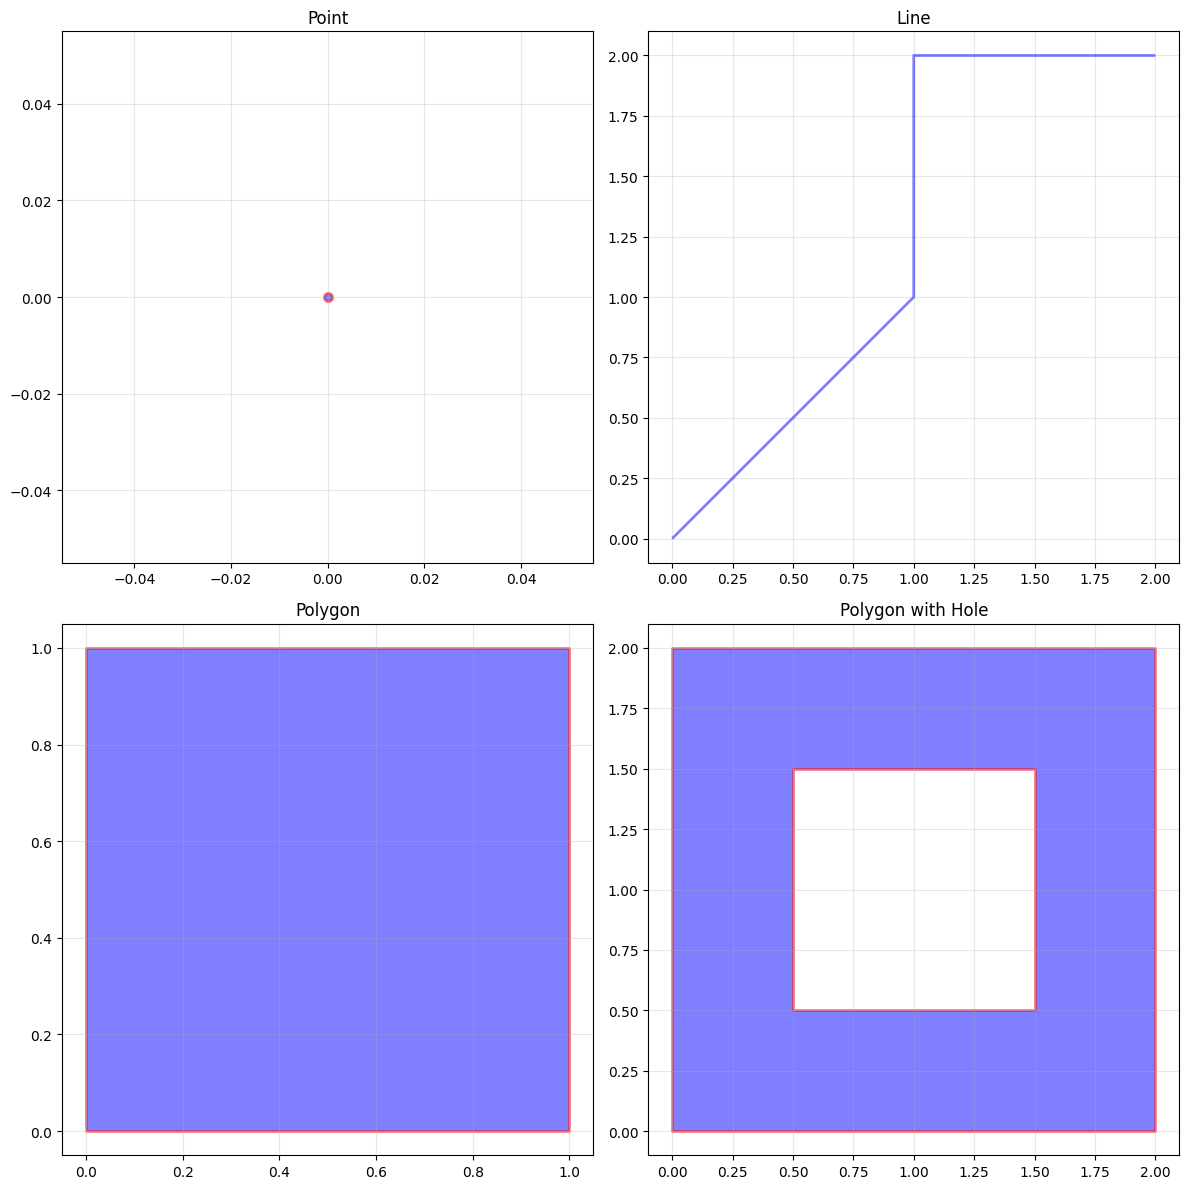

In [15]:
# Create various geometry types
point = Point(0, 0)
line = LineString([(0, 0), (1, 1), (1, 2), (2, 2)])
polygon = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
polygon_with_hole = Polygon(
    [(0, 0), (2, 0), (2, 2), (0, 2)],  # exterior
    [[(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)]]  # hole
)

# Create GeoDataFrame
geometries = gpd.GeoDataFrame({
    'name': ['Point', 'Line', 'Polygon', 'Polygon with Hole'],
    'geometry': [point, line, polygon, polygon_with_hole]
})

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, (ax, (_, row)) in enumerate(zip(axes, geometries.iterrows())):
    gpd.GeoSeries([row.geometry]).plot(ax=ax, color='blue', alpha=0.5, edgecolor='red', linewidth=2)
    ax.set_title(row['name'], fontsize=12)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Reading and Writing Geospatial Data


In [16]:
# Save GeoDataFrame to various formats
output_dir = 'output'
import os
os.makedirs(output_dir, exist_ok=True)

# Save as GeoJSON
cities_gdf.to_file(f'{output_dir}/cities.geojson', driver='GeoJSON')
print("Saved cities.geojson")

# Save as Shapefile
cities_gdf.to_file(f'{output_dir}/cities.shp')
print("Saved cities.shp")

# Read back
cities_read = gpd.read_file(f'{output_dir}/cities.geojson')
print("\nRead back from GeoJSON:")
print(cities_read.head())


Saved cities.geojson
Saved cities.shp

Read back from GeoJSON:
          city  population  latitude  longitude                   geometry
0     New York     8336817   40.7128   -74.0060    POINT (-74.006 40.7128)
1  Los Angeles     3979576   34.0522  -118.2437  POINT (-118.2437 34.0522)
2      Chicago     2693976   41.8781   -87.6298   POINT (-87.6298 41.8781)
3      Houston     2320268   29.7604   -95.3698   POINT (-95.3698 29.7604)
4      Phoenix     1680992   33.4484  -112.0740   POINT (-112.074 33.4484)


## 9. Spatial Relationships and Predicates


Spatial Relationships:
Intersects: True
Contains: False
Within: False
Touches: False
Overlaps: True

Intersection area: 1.00


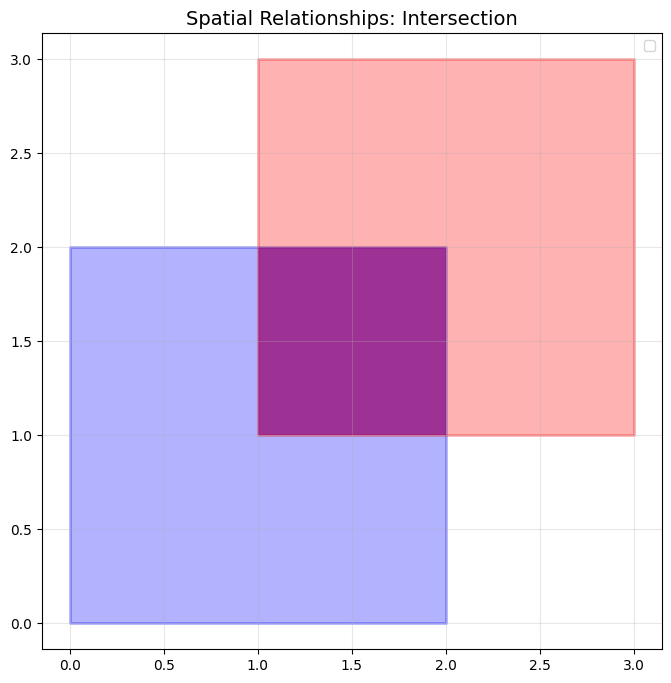

In [17]:
# Create two overlapping polygons
poly1 = Polygon([(0, 0), (2, 0), (2, 2), (0, 2)])
poly2 = Polygon([(1, 1), (3, 1), (3, 3), (1, 3)])

gdf1 = gpd.GeoDataFrame({'name': ['Polygon 1']}, geometry=[poly1])
gdf2 = gpd.GeoDataFrame({'name': ['Polygon 2']}, geometry=[poly2])

# Test various spatial predicates
print("Spatial Relationships:")
print(f"Intersects: {poly1.intersects(poly2)}")
print(f"Contains: {poly1.contains(poly2)}")
print(f"Within: {poly1.within(poly2)}")
print(f"Touches: {poly1.touches(poly2)}")
print(f"Overlaps: {poly1.overlaps(poly2)}")

# Get intersection
intersection = poly1.intersection(poly2)
print(f"\nIntersection area: {intersection.area:.2f}")

# Visualize
fig, ax = plt.subplots(figsize=(8, 8))
gdf1.plot(ax=ax, color='blue', alpha=0.3, edgecolor='blue', linewidth=2, label='Polygon 1')
gdf2.plot(ax=ax, color='red', alpha=0.3, edgecolor='red', linewidth=2, label='Polygon 2')
gpd.GeoSeries([intersection]).plot(ax=ax, color='purple', alpha=0.6, label='Intersection')

plt.title('Spatial Relationships: Intersection', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()


## Summary

In this notebook, we covered:
- Creating GeoDataFrames from scratch
- Basic visualization of geospatial data
- Working with real-world datasets
- Understanding and transforming CRS
- Spatial operations (area, buffers, centroids)
- Spatial joins and relationships
- Creating custom geometries
- Reading and writing geospatial files

These fundamentals form the foundation for more advanced geospatial analysis!
